In [28]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import matplotlib.pyplot as plt

In [29]:
H = dde.Variable(1.0)
# D = dde.Variable(1.0)

In [30]:
'''
24th July, 2023 created by Likun Chen, Wuhan University
This is for testing the PINN parameter estimation, object: syn-machine
EXT Parameters:
    Vi , initial terminal voltage : 1.0 pu
    Ta , voltage regulator time constant : 0.4 sec
    Kf , rate feedback gain : 0.03
SYN Parameters:
    H , inertia constant : 1.7 MWs/MVA
    D , synchronous mechanical damping : 0.12 pu/pu
    Xa , stator leakage reactance : 0.130 pu
    Xd , d-axis unsaturated reactance : 1.79 pu
    Xd' , d-axis unsaturated transient reactance : 0.169 pu
    Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu
    Xq , q-axis unsaturated reactance : 1.71 pu
    Xq' , q-axis unsaturated transient reactance : 0.228 pu
    Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu
For 2-order equation, the state variables are rev (w) and phase angle (delta),
parameters waiting estimated are H , D , Eq' = Ed' = const

For Single Sync-Mach to load system:
    1st test : without damping coefficient D
    d_delta/dt = w - w0                    (1)
    2 * H * d_w/dt = P_mach/w - P_ex/w     (2)

    2nd test : with damping coefficient D = 0.12
    d_delta/dt = w - w0                               (1)
    2 * H * d_w/dt = P_mach/w - P_ex/w - D * (w - w0) (2)
    time， P_ex, delta, P_mach, dw
'''

"\n24th July, 2023 created by Likun Chen, Wuhan University\nThis is for testing the PINN parameter estimation, object: syn-machine\nEXT Parameters:\n    Vi , initial terminal voltage : 1.0 pu\n    Ta , voltage regulator time constant : 0.4 sec\n    Kf , rate feedback gain : 0.03\nSYN Parameters:\n    H , inertia constant : 1.7 MWs/MVA\n    D , synchronous mechanical damping : 0.12 pu/pu\n    Xa , stator leakage reactance : 0.130 pu\n    Xd , d-axis unsaturated reactance : 1.79 pu\n    Xd' , d-axis unsaturated transient reactance : 0.169 pu\n    Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu\n    Xq , q-axis unsaturated reactance : 1.71 pu\n    Xq' , q-axis unsaturated transient reactance : 0.228 pu\n    Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu\nFor 2-order equation, the state variables are rev (w) and phase angle (delta),\nparameters waiting estimated are H , D , Eq' = Ed' = const\n\nFor Single Sync-Mach to load system:\n    1st test : without damping coefficien

In [31]:
input_data = pd.read_csv('data/920test1_te.csv', index_col=0)
input_data

,Time,Pe,Tm,delta,Pt,w,Te
0,0.00000,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
1,0.00005,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
2,0.00010,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
3,0.00015,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
4,0.00020,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
...,...,...,...,...,...,...,...
7995,0.39975,0.488091,1.056364,0.578104,0.502388,0.946643,1.070208
7996,0.39980,0.488098,1.056365,0.578137,0.502388,0.946643,1.070199
7997,0.39985,0.488106,1.056365,0.578170,0.502388,0.946642,1.070209
7998,0.39990,0.488113,1.056365,0.578203,0.502388,0.946642,1.070209


In [32]:
input_data = input_data[800:]

In [33]:
input_data.Time -= 0.02

C:\Users\chenl\AppData\Local\Temp\ipykernel_7992\3353039809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.Time -= 0.02


In [34]:
input_data.set_index('Time',inplace=True)
input_data

,Pe,Tm,delta,Pt,w,Te
Time,,,,,,
0.02000,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
0.02005,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
0.02010,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
0.02015,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
0.02020,-0.001771,0.000000,-0.000710,-0.001771,1.000507,0.000000
...,...,...,...,...,...,...
0.37975,0.488091,1.056364,0.578104,0.502388,0.946643,1.070208
0.37980,0.488098,1.056365,0.578137,0.502388,0.946643,1.070199
0.37985,0.488106,1.056365,0.578170,0.502388,0.946642,1.070209


In [35]:
x = input_data.index.to_numpy()
x

array([0.02   , 0.02005, 0.0201 , ..., 0.37985, 0.3799 , 0.37995])

In [36]:
y = input_data.to_numpy()
y

array([[-1.77114809e-03,  0.00000000e+00, -7.09601712e-04,
        -1.77111252e-03,  1.00050723e+00,  0.00000000e+00],
       [-1.77114807e-03,  0.00000000e+00, -7.09598383e-04,
        -1.77111250e-03,  1.00050723e+00,  0.00000000e+00],
       [-1.77114805e-03,  0.00000000e+00, -7.09609055e-04,
        -1.77111248e-03,  1.00050723e+00,  0.00000000e+00],
       ...,
       [ 4.88105517e-01,  1.05636492e+00,  5.78169930e-01,
         5.02387957e-01,  9.46642333e-01,  1.07020887e+00],
       [ 4.88112627e-01,  1.05636518e+00,  5.78203074e-01,
         5.02387811e-01,  9.46642102e-01,  1.07020913e+00],
       [ 4.88119734e-01,  1.05636544e+00,  5.78236217e-01,
         5.02387665e-01,  9.46641872e-01,  1.07020913e+00]])

In [37]:
geom = dde.geometry.TimeDomain(0, x[-1])

In [38]:
# H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
def Microgrid_system(x, y):
    """Modified Lorenz system (with exogenous input).
    H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
    """
    # time = x
    P_ex, T_m, delta, Pt, w, Te = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6]
    
    # d_delta_dt = dde.grad.jacobian(y, x, i=3)
    dw_dt = dde.grad.jacobian(y, x, i=4)
    # dw_dt = dde.grad.hessian(y, x, i=1)
    return [
        2 * H * dw_dt - T_m + Te
    ]


In [39]:
# class ex_func2():
#     def __init__(self, input_data):
#         self.input_data = input_data
#     def fun(self, t):
#         t = t.reshape(-1, )
#         return self.input_data.iloc[t]['Subsystem #1|CTLs|Vars|PGEN'].to_numpy().reshape(-1, 1)

In [40]:
observe_t = x.reshape(-1, 1)
ob_y = y
ob_y

array([[-1.77114809e-03,  0.00000000e+00, -7.09601712e-04,
        -1.77111252e-03,  1.00050723e+00,  0.00000000e+00],
       [-1.77114807e-03,  0.00000000e+00, -7.09598383e-04,
        -1.77111250e-03,  1.00050723e+00,  0.00000000e+00],
       [-1.77114805e-03,  0.00000000e+00, -7.09609055e-04,
        -1.77111248e-03,  1.00050723e+00,  0.00000000e+00],
       ...,
       [ 4.88105517e-01,  1.05636492e+00,  5.78169930e-01,
         5.02387957e-01,  9.46642333e-01,  1.07020887e+00],
       [ 4.88112627e-01,  1.05636518e+00,  5.78203074e-01,
         5.02387811e-01,  9.46642102e-01,  1.07020913e+00],
       [ 4.88119734e-01,  1.05636544e+00,  5.78236217e-01,
         5.02387665e-01,  9.46641872e-01,  1.07020913e+00]])

In [47]:
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)
observe_y3 = dde.icbc.PointSetBC(observe_t, ob_y[:, 3:4], component=3)
observe_y4 = dde.icbc.PointSetBC(observe_t, ob_y[:, 4:5], component=4)
observe_y5 = dde.icbc.PointSetBC(observe_t, ob_y[:, 5:6], component=5)

In [ ]:
ic1 = dde.icbc.IC(geom, lambda X: -0.001771, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 0, boundary, component=1)

In [42]:
data = dde.data.PDE(
    geom,
    Microgrid_system,
    [],
    # num_domain=7200,
    # num_boundary=0,
    anchors=observe_t,
#     auxiliary_var_function=ex_func2(input_data).fun,
)

In [43]:
net = dde.nn.FNN([1] + [40] * 3 + [6], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[H])



Compiling model...
Building feed-forward neural network...
'build' took 0.185940 s



C:\env\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.409251 s



In [44]:
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([H], period=200, filename=fnamevar)
model.train(iterations=15000, callbacks=[variable])

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [2.86e-01]    [2.86e-01]    []  
1000      [1.64e-06]    [1.64e-06]    []  
2000      [1.16e-06]    [1.16e-06]    []  
3000      [6.61e-07]    [6.61e-07]    []  
4000      [3.65e-07]    [3.65e-07]    []  
5000      [2.42e-07]    [2.42e-07]    []  
6000      [1.63e-07]    [1.63e-07]    []  
7000      [1.18e-07]    [1.18e-07]    []  
8000      [7.94e-08]    [7.94e-08]    []  
9000      [5.35e-08]    [5.35e-08]    []  
10000     [2.78e-07]    [2.78e-07]    []  
11000     [2.33e-08]    [2.33e-08]    []  
12000     [1.61e-08]    [1.61e-08]    []  
13000     [3.69e-05]    [3.69e-05]    []  
14000     [6.02e-09]    [6.02e-09]    []  
15000     [3.72e-09]    [3.72e-09]    []  

Best model at step 15000:
  train loss: 3.72e-09
  test loss: 3.72e-09
  test metric: []

'train' took 138.297711 s



(<deepxde.model.LossHistory at 0x18231a85f10>,
 <deepxde.model.TrainState at 0x18231929290>)

In [45]:
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "k-")

plt.plot(range(l), np.ones(Chat[:, 0].shape) * 1.7, "r--")
plt.plot(range(l), np.ones(Chat[:, 1].shape) * 0.12, "k--")

plt.legend(["Hhat", "Dhat","True H", "True D"], loc="right")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

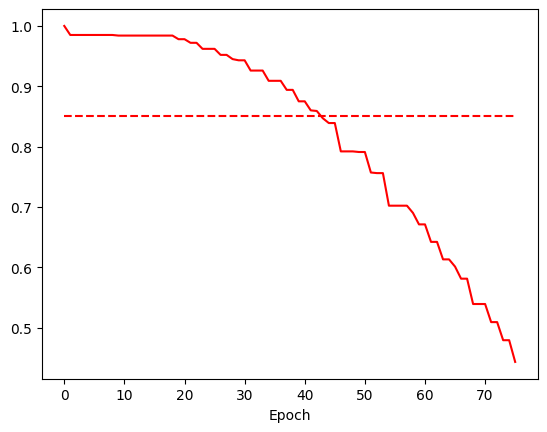

In [46]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * 0.85, "r--")
plt.xlabel("Epoch")

yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
plt.legend(["P_ex", "delta", "P_mach", "dw", "hP_ex", "hdelta", "hP_mach", "hdw"])
plt.title("Training data")
plt.show()